Este es un Jupyter Notebook donde se hace uso de los algoritmos Genéticos para resolver el problema de las 8 reinas.

El problema de las 8 reinas consiste en acomodar 8 reinas en un tablero de ajedrez de manera que niguna pueda comerse a otra. 8 reinas pueden acomodarse en un tablero de 16,777,216 maneras distintas, sin embargo, solo hay 12 maneras únicas para resolver el problema.

Este código tiene como objetivo encontrar las distintas maneras (8) de resolver el problema usando algoritmos genéticos.

In [34]:
import numpy as np
import random
import matplotlib.pyplot as plt

¿Cómo codificaremos un tablero de ajedrez?

Usaremos una lista compuesta de números que van del 0 al 8, el indice de la lista es la columna y el valor la fila, es decir, la lista [6,4,2,0,5,7,1,3] se ve como la siguiente imágen:

![Getting Started](./example.jpeg)

La función objetivo.

La función objetivo es la manera en que un algoritmo genético sabe cómo optimizar el problema, aqui, contaremos cuántas reinas están en peligro de ser 
'comidad' por cada reina, con la siguiente relación matemática:

![Getting Started](./funcionObjetivo.png)

donde "r" es el número de fila donde está posicionada la reina, 'd' es la distanca absoluta entre la columna de la reina y otra columna 'j' arbitraria, en la cual queremos checar si hay alguna reina.
Es decir, para esta reina en el (0,4), y específicamente para la columna 6, no pueden haber otras reinas en las filas:

$$(r-d) \rightarrow (4-(6-3)) \rightarrow (1)$$

$$(r) \rightarrow (4)$$

$$(r+d) \rightarrow (4+(6-3)) \rightarrow (7)$$




Por lo que la función 'penalty', usa la anterior relación matemática para contar, por cada reina en el tablero, cuántas otras reinas están en peligro. El algoritmo genético optimizará los tableros favoreciendo a aquellos que tengan menor cantidad de reinas en peligro.  

In [35]:
#fitness function

def penalty(array):
    #lista vacia, va a almacenar la cantidad de clashes en cada chessboard
    Lattacks=[]
    #por cada chessboard
    for chessboard in array:
        #totales de ataques que hay en la mesa
        attack=0
        # por cada reina en la mesa
        for queen in chessboard:
            #obtenemos su fila
            row=queen
            #su columna
            i=chessboard.index(row)
            #checamos todas las columnas
            for column in range(8):
                #que no sean la misma de la reina que estamos calculando
                if column!=i:
                    #distancia para las diagonales
                    d=abs(i-column)
                    r,rmd,rpd=row,row-d,row+d
                    if (chessboard[column]==r) or (chessboard[column]==rmd) or (chessboard[column]==rpd):
                        attack+=1
        #guardamos cantidad de ataques que hubo en este chessboard                
        Lattacks.append(attack)
        #esto ya no es necesario pero me da culo borrarlo 
        Nattacks=list(np.array(Lattacks))
    return array, Nattacks

#regresa el array de chessboards y un array de la cantidad de ataques en cada chesboard, queremos premiar aquellos que tengan un menornumero    

La función 'selection' lo que hace es escoger a los 'padres' (tableros) que posteriormente se 'reproducirán' (formará un nuevo tablero), de manera estocásticaa, es decir, con probabilidad, aquellos tableros con menos reinas en peligros tienen mayor probabilidad de ser escogidas.

In [36]:
#seleccion padres
def selection(chessboards,fitness):
    #definimos el peso, es inversamente proporcional, es decir, a menor clashes, mayor probabilidad
    weights= 1/np.array(fitness)
    # obtenemos un padre con weighted choice
    father=random.choices(population=chessboards,weights=weights,k=1)
    # segunda lista para obtener una madre sin repetir al padre
    segundaLista=chessboards.copy()
    #obtenemos el indice del padre obtenido
    indicePAPA=chessboards.index(father[0])
    #eliminamos al padre de la segunda lista
    segundaLista.pop(indicePAPA)
    #eliminamos la probabilidad del obtenido para no volver a obtenerlo y tener mismos tamaños
    fitness2=fitness.copy()
    fitness2.pop(indicePAPA)
    weights2=1/np.array(fitness2)
    #obtenemos madre con la nueva list de chessboards y pesos, que no tienen la info del padre
    mother=random.choices(population=segundaLista,weights=weights2,k=1)
    # print(mother)
    return father[0], mother[0]

La función 'reproducciónYmutacion' usara a los padres electos para formar dos hijos, es decir, dos tableros nuevos que son una especie de combinación del padre y madre.

In [37]:
#self-explanatory
def reproduccionYmutacion(padre,madre,total,pMutacion):
    #punto de cruzamiento
    pCruzamiento=random.randint(0,8)
    #creamos a los hijos iguales
    hijo1=padre.copy()
    hijo2=madre.copy()
    #mezclamos ahora si
    for i in range(0,pCruzamiento):
        hijo1[i],hijo2[i]=hijo2[i],hijo1[i]   
    #mutamos los recien nacidos
    p=random.random()
    #para que la mutacion se de con una probabilidad pM
    if p >= (1-pMutacion):
        #posiciones a intercambiar
        posiciones=random.sample([i for i in range(8)],k=2)
            #mutacion
        hijo1[posiciones[0]],hijo1[posiciones[1]]=hijo1[posiciones[1]],hijo1[posiciones[0]]
        #posiciones a intercambiar del hijo 2
        posiciones=random.sample([i for i in range(8)],k=2)
            #mutacion
        hijo2[posiciones[0]],hijo2[posiciones[1]]=hijo2[posiciones[1]],hijo2[posiciones[0]]
    #añadimos las nuevas chessboards a las soluciones
    total.append(hijo1)
    total.append(hijo2)
    return total

La función 'top100' escoge los 100 mejores tableros para repetir el ciclo, esto con fines de que la cantidad de tableros registrados se mantenga en 100. 

In [38]:
#funcion para quedarnos unicamente con lo top 100 chessboards con menos choques

def top100(chessboards,fitness):
    #creamos una tupla de listas sorteada y el [:100] es para escoger los primeros 100 (los menores 100)
    zip1=sorted(zip(fitness, chessboards), reverse=False)[:100]
    #unpack
    fitness,chessboards=[i for i, j in zip1], [j for i, j in zip1]
    return chessboards,fitness

Aqui iniciamos el algoritmo donde: 

* Definimos el número máximo de iteraciones que queremos permitir
* Creamos 3 tableros iniciales aleatorios.
* Fijamos la probabilidad de qu algun 'hijo' mute (cambie aleatoriamente la posicion de dos reinas). 
* Checamos la aptitud de los 3 tableros creados, es decir, usamos la funcion objetivo para contar las reinas en peligro.
* * Iniciamos el ciclo donde se selecciona un padre y una madre
* * Se reproducen los padres
* * Calculamos aptitud de todos los tableros
* * Nos quedamos únicamente con el top 100
* * Repetir hasta encontrar un tablero con 0 colisiones, o se llegue al numéro maximo de iteraciones deseadas
* Visualizar Resultado.



In [39]:
#iniciamos proceso
maxIteraciones=10000
iteraciones=0
solutions=[]
initialN=3
#probabilidad mutacion
pMutacion=0.8
#---------poblacion INICIAL-------------
#posiciones posible, la usamos para evitar duplicados
positions=range(0,8)
#creamos población inicial
for i in range(initialN):
    #.sample para evitar duplicados, pedimos una lista aleatoria de 8 valores de positions
    chessboard=random.sample(positions,8)
    solutions.append(chessboard)
print(solutions)

#---------funcion aptitud INICIAL-------------
r,fitness=penalty(solutions)
print(r,fitness)      

#ciclo
while (iteraciones<=maxIteraciones and (0 not in fitness)):
    #padres
    padre,madre=selection(r,fitness)
    #reproduccion
    r=reproduccionYmutacion(padre,madre,r,pMutacion)
    #volvemos a calcular fitness
    r,fitness=penalty(r)
    #eliminamos los menos aptos
    r,fitness=top100(r,fitness)     
    iteraciones+=1

#buscamos el indice donde hay 0 clashes
index=fitness.index(0)
#imprimimos tablero correspondiente
print('El arreglo de ajedrez es: ',r[index] ,'encontrado despues de: ',iteraciones,' iteraciones')
print(' ')
print('¿Cómo interpretar el resultado?')
print('Ejemplo FIJO: Para leer el arreglo: el indice de la lista es la columna y el valor la fila, es decir, la lista [6,4,2,0,5,7,1,3] se ve como la siguiente imágen:')
 

[[1, 5, 0, 4, 2, 3, 7, 6], [4, 3, 2, 5, 6, 7, 0, 1], [3, 6, 0, 5, 4, 1, 7, 2]]
[[1, 5, 0, 4, 2, 3, 7, 6], [4, 3, 2, 5, 6, 7, 0, 1], [3, 6, 0, 5, 4, 1, 7, 2]] [16, 22, 2]
El arreglo de ajedrez es:  [0, 6, 3, 5, 7, 1, 4, 2] encontrado despues de:  266  iteraciones
 
¿Cómo interpretar el resultado?
Ejemplo FIJO: Para leer el arreglo: el indice de la lista es la columna y el valor la fila, es decir, la lista [6,4,2,0,5,7,1,3] se ve como la siguiente imágen:


(-0.5, 253.5, 257.5, -0.5)

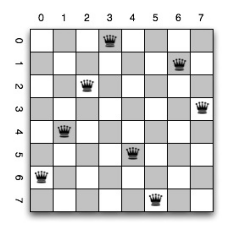

In [40]:
im = plt.imread('example.jpeg')
plt.imshow(im)
plt.axis('off')

Text(0.5, 1.0, 'Chessboard')

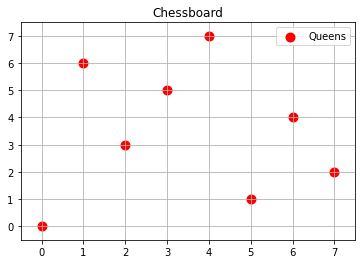

In [41]:
# graficamos nomas pa ver
Queens=r[index]
x=[i for i in range(8)]
y=np.array(x)
plt.scatter(x,Queens,color = 'red',lw=4)
plt.grid()
plt.xlim(-0.5,7.5)
plt.ylim(-0.5,7.5)
plt.legend(['Queens'])
plt.title("Chessboard")


Text(0.5, 1.0, 'Chessboard')

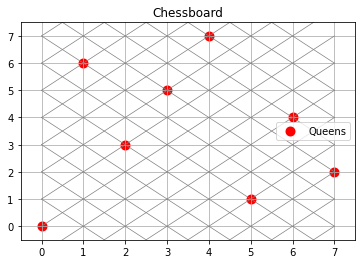

In [42]:
#Trayectorias de cada reina
plt.scatter(x,Queens,color = 'red',lw=4)
plt.grid()
lw=.7
colorlw='grey'
plt.plot(x,y,lw=lw,color=colorlw)
plt.plot(x,y-1,lw=lw,color=colorlw)
plt.plot(x,y-2,lw=lw,color=colorlw)
plt.plot(x,y-3,lw=lw,color=colorlw)
plt.plot(x,y-4,lw=lw,color=colorlw)
plt.plot(x,y-5,lw=lw,color=colorlw)
plt.plot(x,y-6,lw=lw,color=colorlw)
plt.plot(x,y-7,lw=lw,color=colorlw)
plt.plot(x,y+1,lw=lw,color=colorlw)
plt.plot(x,y+2,lw=lw,color=colorlw)
plt.plot(x,y+3,lw=lw,color=colorlw)
plt.plot(x,y+4,lw=lw,color=colorlw)
plt.plot(x,y+5,lw=lw,color=colorlw)
plt.plot(x,y+6,lw=lw,color=colorlw)
plt.plot(x,y+7,lw=lw,color=colorlw)
#inversas
plt.plot(x,-y+1,lw=lw,color=colorlw)
plt.plot(x,-y+2,lw=lw,color=colorlw)
plt.plot(x,-y+3,lw=lw,color=colorlw)
plt.plot(x,-y+4,lw=lw,color=colorlw)
plt.plot(x,-y+5,lw=lw,color=colorlw)
plt.plot(x,-y+6,lw=lw,color=colorlw)
plt.plot(x,-y+7,lw=lw,color=colorlw)
plt.plot(x,-y+8,lw=lw,color=colorlw)
plt.plot(x,-y+9,lw=lw,color=colorlw)
plt.plot(x,-y+10,lw=lw,color=colorlw)
plt.plot(x,-y+11,lw=lw,color=colorlw)
plt.plot(x,-y+12,lw=lw,color=colorlw)
plt.plot(x,-y+13,lw=lw,color=colorlw)
plt.xlim(-0.5,7.5)
plt.ylim(-0.5,7.5)
plt.legend(['Queens'])
plt.title("Chessboard")